In [10]:
import satellite_images_nso.api.nso_georegion as nso
import satellite_images_nso.api.sat_manipulator as sat_manipulator
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from dotenv import load_dotenv
from tools import *
import os

In [11]:
load_dotenv()

user_name = os.getenv('API_USERNAME')
user_password = os.getenv('API_PASSWORD')

# Fetch the geojson file for the region of interest
path_geojson = get_geojson_path('alkmaar.geojson')

# Get the current working directory (useful in Jupyter notebooks)
current_dir = os.getcwd()  # This will give you the current working directory
parent_dir = os.path.join(current_dir, '..')  # Parent directory
folder_data = str(os.path.join(parent_dir, 'data'))  # Point to the 'data' folder

GeoJSON file path: C:\Users\munib\Desktop\Aanbesteding\Project\Project-Digital-Twin\data\alkmaar.geojson


In [12]:
# The first parameter is the path to the geojson, the second the map where the cropped satellite data will be downloaded, the third is your NSO username and the last your NSO password.
georegion = nso.nso_georegion(
    path_to_geojson=path_geojson,
    output_folder=folder_data,
    username=user_name,
    password=user_password,
)


In [13]:
# This method fetches all the download links with all the satellite images the NSO has which contain the region in the given geojson.
# Max_diff parameters represents the amount of percentage the selected region has to be in the satellite image.
# So 1 is the the selected region has to be fully in the satellite images while 0.7 donates only 70% of the selected region is in the
links = georegion.retrieve_download_links(
    max_diff=0.5, start_date="2022-01-01", end_date="2022-04-01"
)

# Inspect the links
print(f"Found links: {len(links)}")
for link in links:
    print(link)

Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.78837337  4.78808248  4.78757723 ...  4.79008716  4.78986092
   4.78837337]
 [52.51916418 52.51919594 52.51925109 ... 52.51923535 52.51923589
  52.51916418]]
Cloudcov

In [14]:
# This example filters out only 200 cm RGB Infrared Superview satellite imagery in the spring from all the links
season = "Spring"
links_group = []
for link in links:
    # Use 200 cm RGB Infrared Superview satellite imagery to get faster download links
    if "SV" in link and "200cm" in link and "RGBI" in link:
        if (
            sat_manipulator.get_season_for_month(
                int(link.split("/")[len(link.split("/")) - 1][4:6])
            )[0]
            == season
        ):
            links_group.append(link)

# Inspect the filtered links
print(f"Found links in the group: {len(links_group)}")
for link in links_group:
    print(link)

Found links in the group: 1
https://api.satellietdataportaal.nl/v1/download/SV_RD_11bit_RGBI_200cm/20220308_103948_SV1-01


In [16]:
# Downloads a satellite image from the NSO, makes a crop out of it so it fits the geojson region and calculates the NVDI index.
# The output will stored in the output folder.
# The parameters are : link, delete_zip_file = False, delete_source_files = True,  plot=True, in_image_cloud_percentage = False,  add_ndvi_band = False, add_height_band = False
# description of these parameters can be found in the code.
georegion.execute_link(links_group[0],  delete_zip_file=True, plot=False, add_ndvi_band=True)

Starting download to: c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data/20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm.zip
Extracting files
Extracted folder is: c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data/20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm
cropping file c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data/20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm\20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen.tif
New cropped filename: c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data/20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm\20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen_alkmaar_cropped.tif
raster path opened
convert to RD
finished cropping c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data/20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm\20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen.tif
Cropped file is found at: c:/Users/

100%|██████████| 7344/7344 [01:05<00:00, 112.67it/s]


Done with calculating NDVI, saving to: c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data/20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen_alkmaar_cropped_ndvi.tif


'c:/Users/munib/Desktop/Aanbesteding/Project/Project-Digital-Twin/src/../data/20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen_alkmaar_cropped_ndvi.tif'

Most recent TIFF file: C:\Users\munib\Desktop\Aanbesteding\Project\Project-Digital-Twin\data\20220308_103948_SV1-01_SV_RD_11bit_RGBI_200cm_Driehuizen_alkmaar_cropped_ndvi.tif
Number of bands: 5


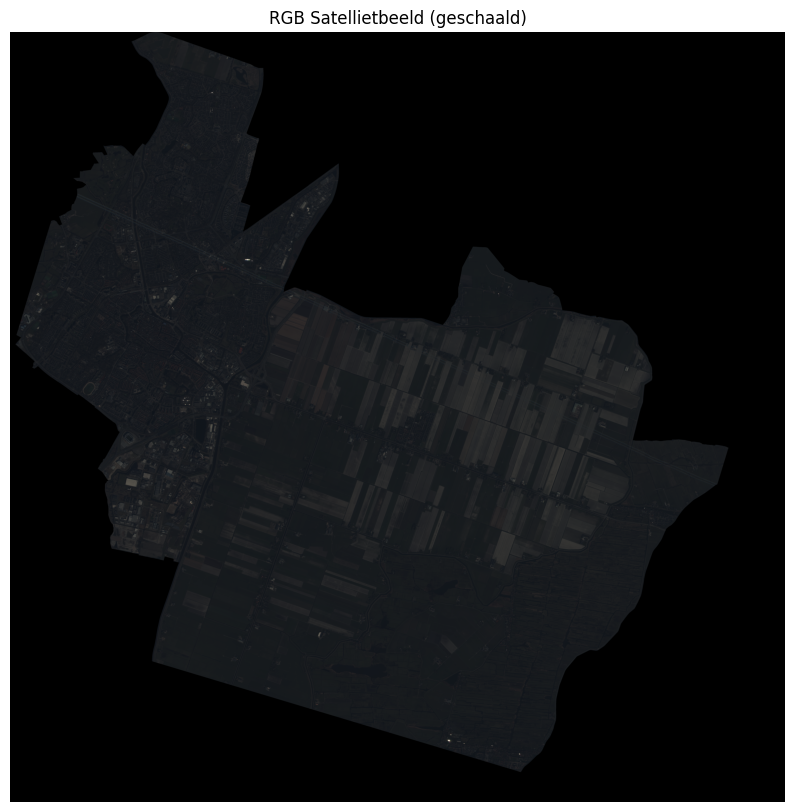

In [17]:
tif_path = get_tif_path()
print(f"Most recent TIFF file: {tif_path}")

# Open het TIFF-bestand
with rasterio.open(tif_path) as src:
    red = src.read(3).astype(np.float32)
    green = src.read(2).astype(np.float32)
    blue = src.read(1).astype(np.float32)
    nir= src.read(4).astype(np.float32)

    # Normaliseer: schaal van 0–255 of 0–1 afhankelijk van bitdiepte
    max_val = max(red.max(), green.max(), blue.max())
    red /= max_val
    green /= max_val
    blue /= max_val
    nir /= max_val

    # Stapel de RGB-kanalen
    rgb = np.stack((red, green, blue), axis=-1)

    print(f"Number of bands: {src.count}")

# Visualiseer de afbeelding
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("RGB Satellietbeeld (geschaald)")
plt.axis("off")
plt.show()